# Imports

In [1]:
import pandas_ta as ta
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
from scipy.stats import t 

from isyatirimhisse import StockData

plt.style.use('fivethirtyeight')

In [2]:
df = pd.DataFrame()
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

Define function to generate signals based on RSI and linear regression

In [5]:
def generate_buy_sell_signals(symbol, start_date='01-01-2003', frequency='1d', exchange='0', alpha=0.2, buy_threshold=40, sell_threshold=60, buffer_percentage=0, RSI_length=14):

    stock_data = StockData()
    data = stock_data.get_data(symbols=symbol, start_date=start_date, frequency=frequency, exchange=exchange)

    data = data[['DATE', 'CLOSING_TL']]
    data['CLOSING_TL'] = np.log(data['CLOSING_TL'])
    data = data.rename(columns={'CLOSING_TL': symbol})
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data.set_index('DATE')

    # Calculating RSI and linear regression using pandas_ta library
    data['RSI'] = ta.rsi(close=data[symbol], length=RSI_length)
    data['Time'] = np.arange(1, len(data) + 1)
    linreg_result = ta.linear_regression(data['Time'], data[symbol])
    data['Fitted'] = linreg_result['line']
    data = data.dropna()

    # Calculating prediction intervals for linear regression
    degrees_of_freedom = len(data) - 2
    t_crit = t.ppf(1 - alpha / 2, degrees_of_freedom)
    beta0 = linreg_result['a']
    beta1 = linreg_result['b']
    data['Lower'] = beta0 + beta1 * data['Time'] - t_crit * np.sqrt(np.mean((data[symbol] - data['Fitted']) ** 2) * (1 + 1 / len(data) + (data['Time'] - data['Time'].mean()) ** 2 / ((data['Time'] - data['Time'].mean()) ** 2).sum()))
    data['Upper'] = beta0 + beta1 * data['Time'] + t_crit * np.sqrt(np.mean((data[symbol] - data['Fitted']) ** 2) * (1 + 1 / len(data) + (data['Time'] - data['Time'].mean()) ** 2 / ((data['Time'] - data['Time'].mean()) ** 2).sum()))

    # Initializing lists for buy and sell signals
    buy_signals = []
    sell_signals = []
    last_signal = None

    for i in range(len(data)):
        if data['RSI'].iloc[i] > sell_threshold:
            if last_signal != 'sell' and last_signal is not None:
                value_upper = data['Upper'].iloc[i] * (1 + buffer_percentage / 100) if data['Upper'].iloc[i] >= 0 else data['Upper'].iloc[i] * (1 - buffer_percentage / 100)
                if data[symbol].iloc[i] > value_upper:
                    sell_signals.append(data[symbol].iloc[i])
                    buy_signals.append(np.nan)
                    last_signal = 'sell'
                else:
                    sell_signals.append(np.nan)
                    buy_signals.append(np.nan)
            else:
                sell_signals.append(np.nan)
                buy_signals.append(np.nan)
        elif data['RSI'].iloc[i] < buy_threshold:
            if last_signal != 'buy':
                value_lower = data['Lower'].iloc[i] * (1 - buffer_percentage / 100) if data['Lower'].iloc[i] >= 0 else data['Lower'].iloc[i] * (1 + buffer_percentage / 100)
                if data[symbol].iloc[i] < value_lower:
                    buy_signals.append(data[symbol].iloc[i])
                    sell_signals.append(np.nan)
                    last_signal = 'buy'
                else:
                    buy_signals.append(np.nan)
                    sell_signals.append(np.nan)
            else:
                buy_signals.append(np.nan)
                sell_signals.append(np.nan)
        else:
            buy_signals.append(np.nan)
            sell_signals.append(np.nan)

    data['Buy_Signal_Price'] = buy_signals
    data['Sell_Signal_Price'] = sell_signals

    # data.to_excel('check_signals.xlsx')

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 12))

    ax1.set_title(f'{symbol} - for Educational Purposes Only', fontsize=16)

    ax1.plot(data.index, data[symbol], color='gray', alpha=.5)
    ax1.set_ylabel("Log Price")

    ax1.plot(data.index, data['Fitted'], label='Fitted', linestyle='--', color='blue')
    ax1.plot(data.index, data['Lower'], label='Lower Band', linestyle='--', color='orange')
    ax1.plot(data.index, data['Upper'], label='Upper Band', linestyle='--', color='purple')

    buy_signal_indices = data.index[data['Buy_Signal_Price'].notnull()]
    ax1.plot(buy_signal_indices, data.loc[buy_signal_indices, symbol], '^', markersize=12, color='green', label='Buy Signal')
    sell_signal_indices = data.index[data['Sell_Signal_Price'].notnull()]
    ax1.plot(sell_signal_indices, data.loc[sell_signal_indices, symbol], 'v', markersize=12, color='red', label='Sell Signal')

    ax1.legend()

    ax2.plot(data.index, data['RSI'], color='red')
    ax2.axhline(y=buy_threshold, color='black', linestyle='--')
    ax2.axhline(y=sell_threshold, color='black', linestyle='--')

    plt.savefig(f'{symbol}_plot.png')

    plt.show()

    signals_df = pd.DataFrame(columns=['DATE', 'STOCK', 'BUY_SELL', 'PRICE'])
    buy_signals = data.reset_index()[['DATE', 'Buy_Signal_Price']].dropna()
    buy_signals['STOCK'] = symbol
    buy_signals['BUY_SELL'] = 'Buy'
    buy_signals['PRICE'] = np.exp(buy_signals['Buy_Signal_Price'])

    sell_signals = data.reset_index()[['DATE', 'Sell_Signal_Price']].dropna()
    sell_signals['STOCK'] = symbol
    sell_signals['BUY_SELL'] = 'Sell'
    sell_signals['PRICE'] = np.exp(sell_signals['Sell_Signal_Price'])

    if not signals_df.empty:
        signals_df = pd.concat([signals_df, buy_signals[['DATE', 'STOCK', 'BUY_SELL', 'PRICE']]], ignore_index=True)
        signals_df = pd.concat([signals_df, sell_signals[['DATE', 'STOCK', 'BUY_SELL', 'PRICE']]], ignore_index=True)
    else:
        signals_df = pd.concat([buy_signals[['DATE', 'STOCK', 'BUY_SELL', 'PRICE']], sell_signals[['DATE', 'STOCK', 'BUY_SELL', 'PRICE']]], ignore_index=True)

    return signals_df


Call our funtion for different tickers 

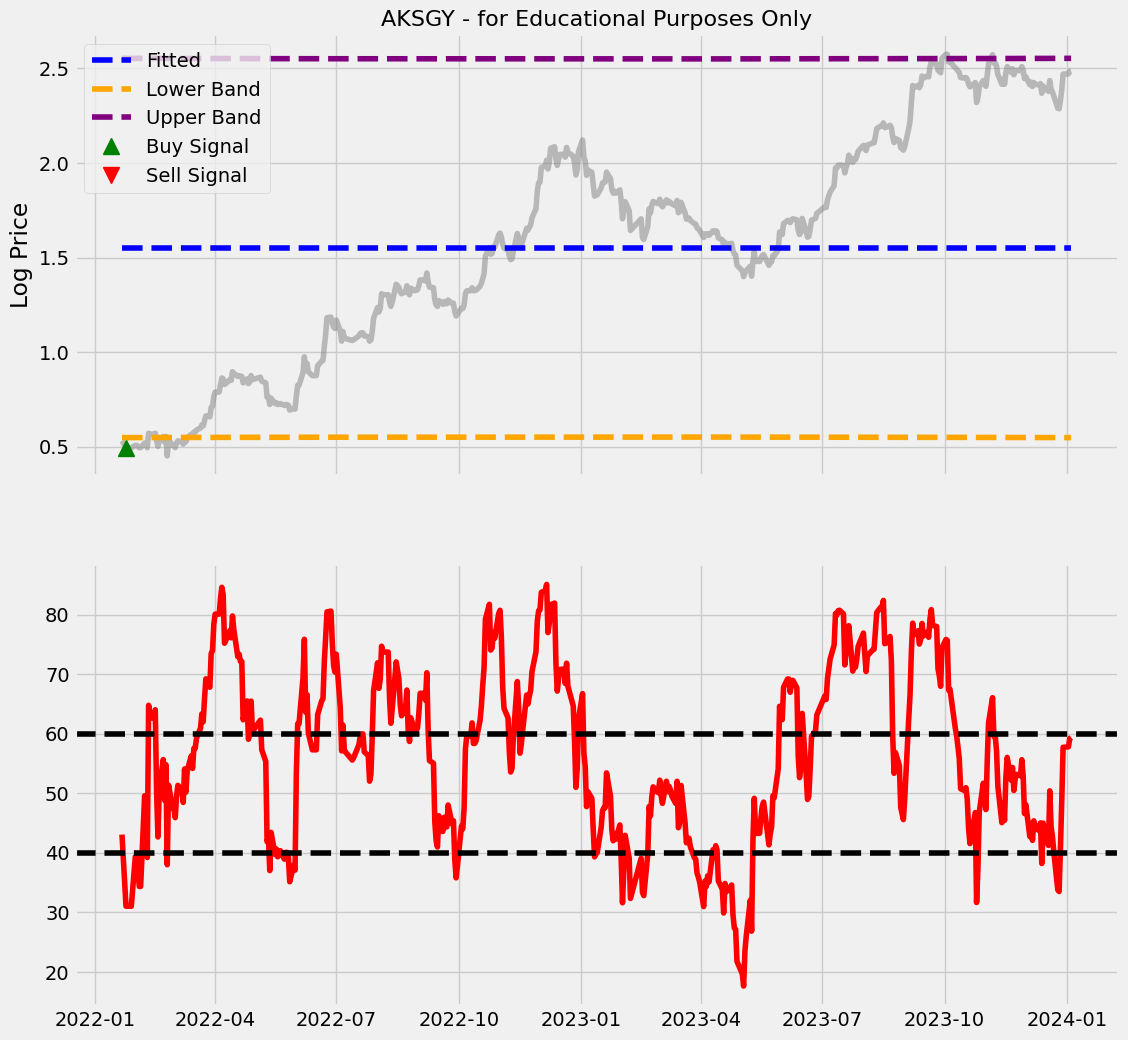

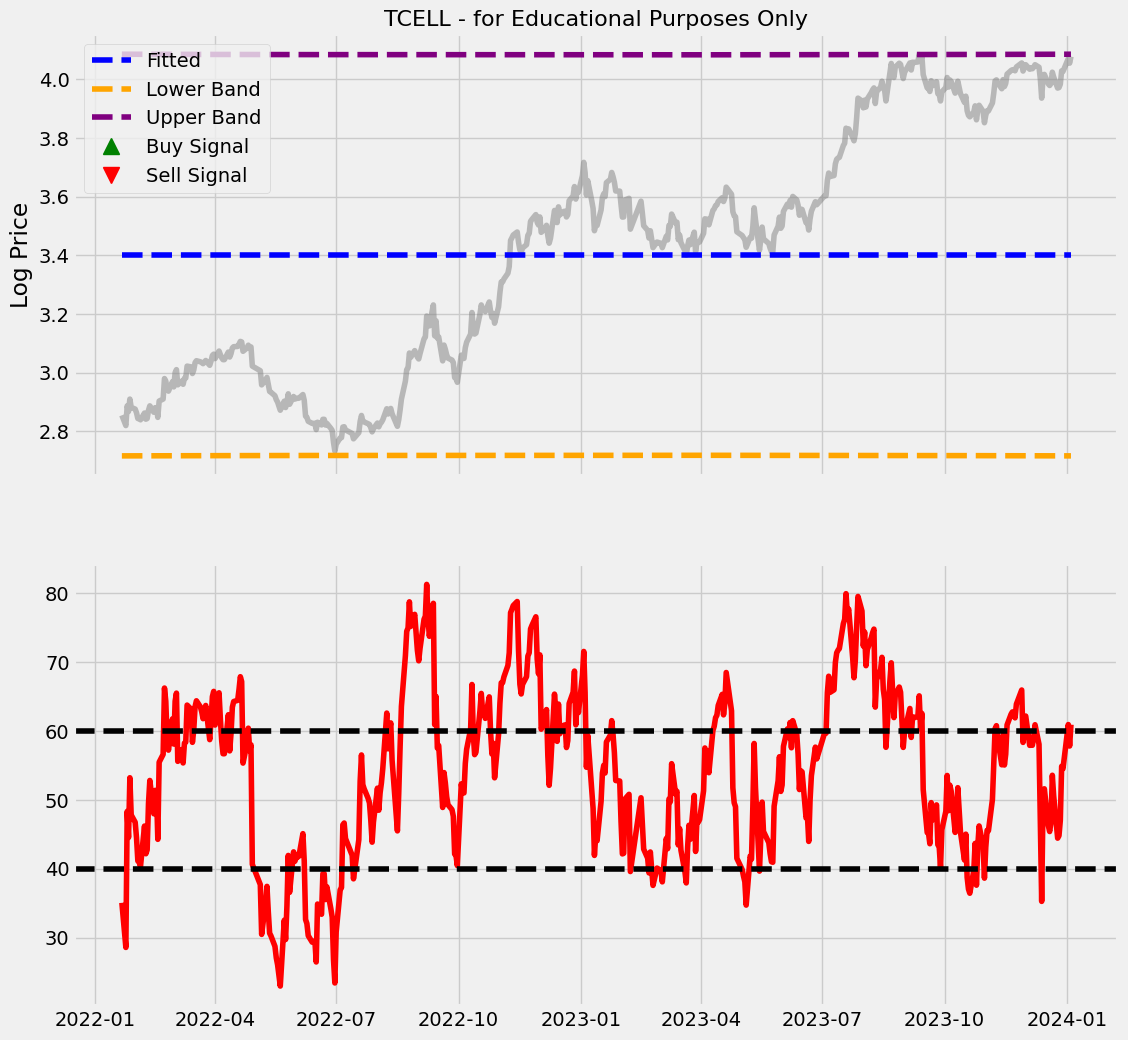

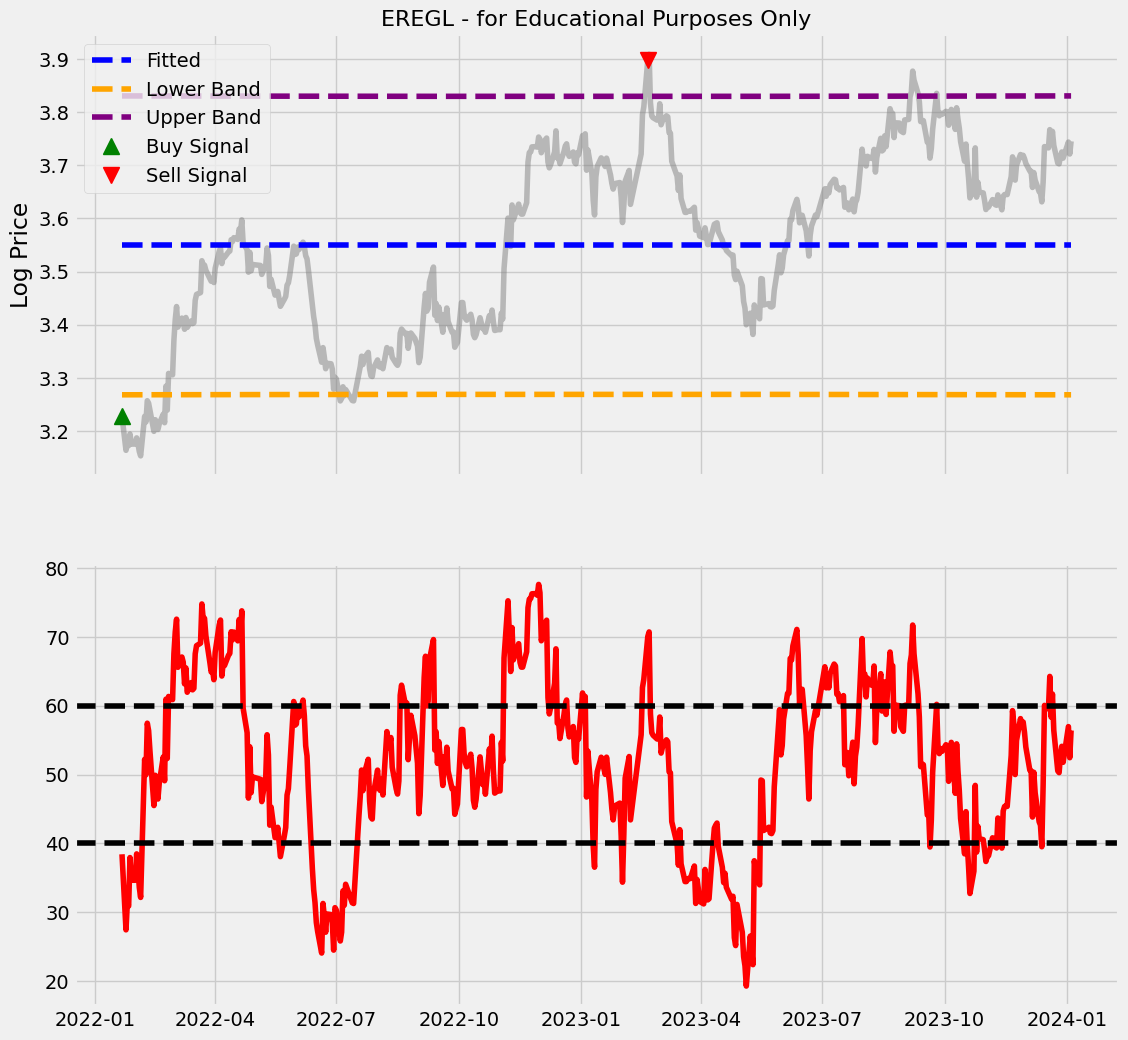

In [18]:
def main():
    """ 
    symbol : Ticker of stock
    start_data : Start date of analyse
    frequency: Data frequency
    exchange: Currency
    alpha : The alpha value for the prediction interval
    buy_threshold: RSI threshold for buy signal
    sell_threshold: RSI threshold for sell signal
    buffer_percentage: An additional margin percentage for the buy or sell signal
    RSI_length: Number of days for RSI

    """
    symbols = ['AKSGY','TCELL','EREGL']

    all_signals = pd.DataFrame()

    for symbol in symbols:
        signals_df = generate_buy_sell_signals(
            symbol,
            start_date='01-01-2022',
            frequency='1d',
            exchange='0',
            alpha=0.1,
            buy_threshold=40,
            sell_threshold=60,
            buffer_percentage=1,
            RSI_length=14
        )
        all_signals = pd.concat([all_signals, signals_df])

    all_signals.to_excel("all_buy_sell_signals.xlsx", index=False)

if __name__ == "__main__":
    main()